In [ ]:
!nvidia-smi

Tue Sep 15 16:23:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 890kB 4.7MB/s 
     |████████████████████████████████| 1.1MB 24.4MB/s 
     |████████████████████████████████| 3.0MB 38.8MB/s 
     |████████████████████████████████| 890kB 56.5MB/s 


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import transformers 
from transformers import BertModel,BertTokenizer,BertForSequenceClassification,TFDistilBertModel,Trainer, TrainingArguments,AdamW,get_linear_schedule_with_warmup
import tensorflow as tf

import torch
from torch import nn, optim
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
# from torch.optim import AdamW

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# initialize Variables
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
MAX_LEN=100
RANDOM_SEED = 42

%matplotlib inline

In [ ]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'


In [ ]:
'''
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)
'''

'\n# Detect hardware, return appropriate distribution strategy\ntry:\n    # TPU detection. No parameters necessary if TPU_NAME environment variable is\n    # set: this is always the case on Kaggle.\n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()\n    print(\'Running on TPU \', tpu.master())\nexcept ValueError:\n    tpu = None\n\nif tpu:\n    tf.config.experimental_connect_to_cluster(tpu)\n    tf.tpu.experimental.initialize_tpu_system(tpu)\n    strategy = tf.distribute.experimental.TPUStrategy(tpu)\nelse:\n    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.\n    strategy = tf.distribute.get_strategy()\n\nprint("REPLICAS: ", strategy.num_replicas_in_sync)\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_path = '/content/drive/My Drive/DataSets'

In [ ]:
spam = pd.read_csv('/content/drive/My Drive/DataSets/spam.csv',encoding='latin-1')
spam.dropna(how="any", inplace=True, axis="columns")
spam.columns = ['label', 'message']
spam.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
spam.head(1).T

,0
label,ham
message,"Go until jurong point, crazy.. Available only ..."


In [ ]:
spam.label = spam.label.map({'ham':0,'spam':1})

Text(0.5, 0, 'spam and ham')

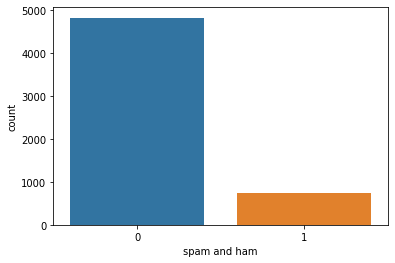

In [ ]:
sns.countplot(spam.label)
plt.xlabel('spam and ham')

In [ ]:
spam.head(5)

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
y = spam.label.values
X = spam.message

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
# text = "Hi My Name is x"
# t1 = tokenizer.encode_plus(text)
# t1

In [ ]:
token_lens = []

for i in X:
  tokens = tokenizer.encode(i,max_length=512,truncation=True)
  token_lens.append(len(tokens))

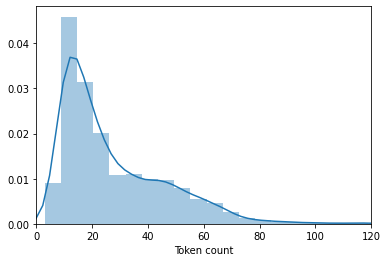

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 120]);
# plt.figure(figsize=(10,10))
plt.xlabel('Token count');

In [ ]:
class SpamHamDataset(Dataset):
  def __init__(self,message,labels,tokenizer,max_len):
    self.message=message
    self.labels = labels
    self.tokenizer=tokenizer
    self.max_len=max_len

  def __len__(self):
    return len(self.message)

  def __getitem__(self,idx):
    message = str(self.message[idx])
    labels = self.labels[idx]

    encoding = self.tokenizer.encode_plus(
      message,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
      )
  
  
    return {
      'spam_message': message,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(labels, dtype=torch.long)
      }

In [ ]:
df_train, df_test = model_selection.train_test_split(spam, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = model_selection.train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
print("Train Shape={0},Test Shape={1},Validation Shape={2}".format(len(df_train),len(df_test),len(df_val)))

Train Shape=5014,Test Shape=279,Validation Shape=279


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SpamHamDataset(
    message=df.message.to_numpy(),
    labels=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1,
  )

In [ ]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
print(data.keys())

dict_keys(['spam_message', 'input_ids', 'attention_mask', 'targets'])


In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


In [ ]:
class SpamHamClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SpamHamClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
class_len = len(spam.label.value_counts().index)

In [ ]:
model = SpamHamClassifier(class_len)
model = model.to(device)

In [ ]:
EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in tqdm(range(EPOCHS)):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train loss 0.014775006545063963 accuracy 0.9970083765456721
Val   loss 0.0005756867261273632 accuracy 1.0



 10%|█         | 1/10 [01:35<14:23, 95.89s/it]

Epoch 2/10
----------
Train loss 0.002673930004490265 accuracy 0.9994016753091344


 20%|██        | 2/10 [03:10<12:43, 95.46s/it]

Val   loss 2.9489577072025793e-05 accuracy 1.0

Epoch 3/10
----------
Train loss 8.14766835611889e-05 accuracy 0.9999999999999999


 30%|███       | 3/10 [04:44<11:06, 95.17s/it]

Val   loss 1.68705281187916e-05 accuracy 1.0

Epoch 4/10
----------
Train loss 2.668527446412033e-05 accuracy 0.9999999999999999


 40%|████      | 4/10 [06:19<09:29, 94.95s/it]

Val   loss 1.297023194031984e-05 accuracy 1.0

Epoch 5/10
----------
Train loss 2.124702539233321e-05 accuracy 0.9999999999999999


 50%|█████     | 5/10 [07:53<07:54, 94.83s/it]

Val   loss 1.0773409687519435e-05 accuracy 1.0

Epoch 6/10
----------
Train loss 1.6993614069648105e-05 accuracy 0.9999999999999999


 60%|██████    | 6/10 [09:28<06:18, 94.73s/it]

Val   loss 9.471407591061305e-06 accuracy 1.0

Epoch 7/10
----------
Train loss 5.89086575928377e-05 accuracy 0.9999999999999999


 70%|███████   | 7/10 [11:02<04:43, 94.65s/it]

Val   loss 8.752433814152027e-06 accuracy 1.0

Epoch 8/10
----------
Train loss 1.6314215088548816e-05 accuracy 0.9999999999999999


 80%|████████  | 8/10 [12:37<03:09, 94.58s/it]

Val   loss 8.364357502917604e-06 accuracy 1.0

Epoch 9/10
----------
Train loss 1.426620326655773e-05 accuracy 0.9999999999999999


 90%|█████████ | 9/10 [14:11<01:34, 94.57s/it]

Val   loss 8.318826631794865e-06 accuracy 1.0

Epoch 10/10
----------
Train loss 1.51161136944987e-05 accuracy 0.9999999999999999


100%|██████████| 10/10 [15:46<00:00, 94.62s/it]

Val   loss 8.318826631794865e-06 accuracy 1.0



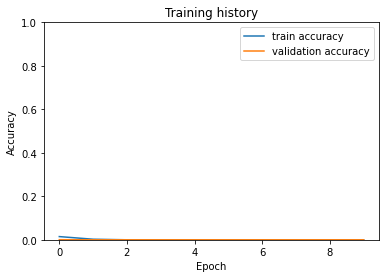

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);